### Data import, model and function creations

In [ ]:
# Importing packages needed

import requests
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Fetching the data
url = 'https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/binary/diabetes_scale'
response = requests.get(url)
text_data = response.text

# Splitting the text into lines
lines = text_data.split('\n')

# List to store data in temporarily
data = []

# Iterating through each line and appending to data list
for line in lines:
    if line:
        parts = line.split()
        # Extracting the outcome (+1 or -1) and converting it to 1 or 0
        outcome = int((int(parts[0])+1)/2)
        # Extracting the predictor variable values
        feature_values = {}
        for part in parts[1:]:
            feature, value = part.split(':')
            feature_values["outcome"] = outcome
            feature_values[int(feature)] = float(value)
        data.append(feature_values)

# Creating a pandas dataframe from the data
diabetes = pd.DataFrame(data)
# Getting rid of rows with missing values
diabetes.dropna(inplace=True)

# Splitting the dataset into the predictor and response variables
data = diabetes.iloc[:,1:9]
outcome = diabetes.iloc[:,0]
X,y = data.to_numpy(),outcome.to_numpy()

# Splitting the data into training, validation, and testing sets
# Temporary sets are used to then split into the validation and testing sets
torch.manual_seed(1748578)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Converting the arrays into PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.long)
X_valid = torch.tensor(X_valid, dtype=torch.float32)
y_valid = torch.tensor(y_valid, dtype=torch.long)



# SINGLE LAYER PERCEPTRON MODEL

# Creating a single-layer Perceptron model
class SL_Perceptron(nn.Module):
    def __init__(self, input_size):
        super(SL_Perceptron, self).__init__()
        self.linear = nn.Linear(input_size, 2)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.linear(x)
        x = self.sigmoid(x)
        return x

def SLP_training_function(learning_rate, num_epochs, input_size):

    # Creating the model, loss function, and optimiser
    model = SL_Perceptron(input_size)
    criterion = nn.CrossEntropyLoss()
    optimiser = optim.Adam(model.parameters(), lr=learning_rate)

    # Lists to stores training and validation losses
    train_losses = []
    valid_losses = []

    # Training loop
    for epoch in range(num_epochs):
        outputs = model.forward(X_train)
        loss = criterion(outputs, y_train)
        optimiser.zero_grad()
        loss.backward()
        train_losses.append(loss.item())
        optimiser.step()

        model.eval()
        with torch.no_grad():
            valid_outputs = model(X_valid)
            valid_loss = criterion(valid_outputs, y_valid)
            valid_losses.append(valid_loss.item())
        model.train()

    # Calculating accuracy and returning results
    model.eval()
    with torch.no_grad():
        valid_outputs = model(X_valid)
        _, preds = torch.max(valid_outputs, 1)
        accuracy = (preds == y_valid).sum().item() / len(y_valid)

        return accuracy, train_losses, valid_losses



# MULTI-LAYER PERCEPTRON MODEL

# Creating a multi-layer Perceptron model
class ML_Perceptron(nn.Module):
    def __init__(self, input_size):
        super(ML_Perceptron, self).__init__()
        self.linear1 = nn.Linear(input_size, 32)
        self.relu = nn.ReLU()
        self.linear2 = nn.Linear(32, 2)

    def forward(self, x):
        x = self.linear1(x)
        x = self.relu(x)
        x = self.linear2(x)
        return x

def MLP_training_function(learning_rate, num_epochs, input_size):

    # Creating the model, loss function, and optimiser
    model = ML_Perceptron(input_size)
    criterion = nn.CrossEntropyLoss()
    optimiser = optim.Adam(model.parameters(), lr=learning_rate)

    # Lists to stores training and validation losses
    train_losses = []
    valid_losses = []

    # Training loop
    for epoch in range(num_epochs):
        outputs = model(X_train)
        loss = criterion(outputs, y_train)
        optimiser.zero_grad()
        loss.backward()
        train_losses.append(loss.item())
        optimiser.step()

        model.eval()
        with torch.no_grad():
            valid_outputs = model(X_valid)
            valid_loss = criterion(valid_outputs, y_valid)
            valid_losses.append(valid_loss.item())
        model.train()

    # Calculating accuracy and returning results
    model.eval()
    with torch.no_grad():
        valid_outputs = model(X_valid)
        _, preds = torch.max(valid_outputs, 1)
        accuracy = (preds == y_valid).sum().item() / len(y_valid)

    return accuracy, train_losses, valid_losses


### Comparing single layer to multi layer

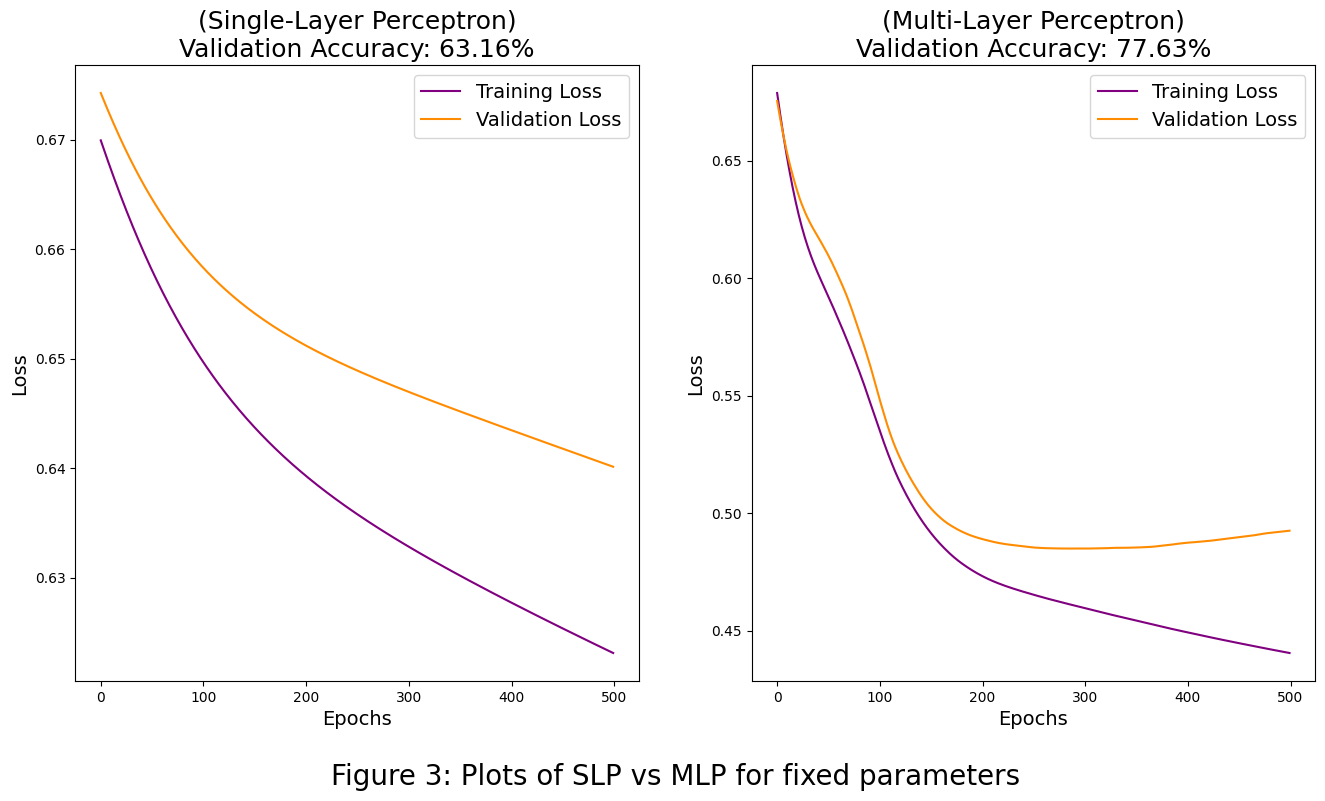

In [ ]:
# Setting a seed to reproduce the data
torch.manual_seed(1748578)

# Creating subplots for each Perceptron model rate in a 1x2 grid
fig, axes = plt.subplots(1, 2, figsize=(16, 8))
fig.subplots_adjust(hspace=0.5)
axes = axes.flatten()

# Setting up baseline parameters for testing, and initialising results list
input_size = X_train.shape[1]
lr = 0.001
epochs = 500
model_results = []

# Getting results of SLP tuning function
accuracy, train_losses, valid_losses = SLP_training_function(lr, epochs, input_size)
model_results.append((lr, epochs, train_losses, valid_losses, accuracy))

# Getting results of MLP tuning function
accuracy, train_losses, valid_losses = MLP_training_function(lr, epochs, input_size)
model_results.append((lr, epochs, train_losses, valid_losses, accuracy))

# Plotting the SLP and MLP models against each other
for i, (lr, epochs, train_losses, valid_losses, accuracy) in enumerate(model_results):
    ax = axes[i]
    ax.plot(train_losses, color="purple", label='Training Loss')
    ax.plot(valid_losses, color="darkorange", label='Validation Loss')
    ax.set_xlabel("Epochs", fontsize=14)
    ax.set_ylabel("Loss", fontsize=14)
    if i == 0:
        ax.set_title(f"(Single-Layer Perceptron)\nValidation Accuracy: {round(accuracy*100, 2)}%", fontsize=18)
    elif i == 1:
        ax.set_title(f"(Multi-Layer Perceptron)\nValidation Accuracy: {round(accuracy*100, 2)}%", fontsize=18)
    ax.legend(fontsize=14)

# Adding a caption to the plot
plt.text(0.5, -0.01, 'Figure 3: Plots of SLP vs MLP for fixed parameters', fontsize=20, ha='center', va='center', transform=fig.transFigure, bbox=dict(boxstyle='round,pad=0.5', edgecolor='white', facecolor='white'))

# Plotting the plots
plt.show()


### Tuning to find best parameters

In [ ]:
# Setting a seed to reproduce the data
torch.manual_seed(1748578)

# Defining lists of learning rates and epochs to tune
input_size = X_train.shape[1]
learning_rates = [0.0001, 0.005, 0.001, 0.05, 0.01]
num_epochs_values = [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]

# Initialising a list to store rows of data
results = []

# Looping through learning rates and epochs for hyperparameter tuning
for lr in learning_rates:
    for num_epochs in num_epochs_values:
        valid_accuracy, train_losses, valid_losses = MLP_training_function(lr, num_epochs, input_size)

        # Now, let's test the model on the test set
        model = ML_Perceptron(input_size)
        criterion = nn.CrossEntropyLoss()
        optimiser = optim.Adam(model.parameters(), lr=lr)
        for epoch in range(num_epochs):
            optimiser.zero_grad()
            outputs = model(X_train)
            loss = criterion(outputs, y_train)
            loss.backward()
            optimiser.step()

        model.eval()
        with torch.no_grad():
            test_outputs = model(X_test)
            _, predicted_test = torch.max(test_outputs, 1)
            test_accuracy = (predicted_test == y_test).sum().item() / len(y_test)

        results.append(pd.DataFrame({'Learning Rate': [lr], 'Epochs': [num_epochs], 'Validation Accuracy': [round(valid_accuracy, 4)], 'Test Accuracy': [round(test_accuracy, 4)]}))

# Concatenating the final results dataframe
final_results = pd.concat(results, ignore_index=True)

# Sorting the dataframe by the Test Accuracy column in descending order
final_results = final_results.sort_values(by='Test Accuracy', ascending=False)

# Printing the head of the results
final_results.head(8)


,Learning Rate,Epochs,Validation Accuracy,Test Accuracy
8,0.0001,900,0.6842,0.8816
21,0.0010,200,0.7632,0.8816
25,0.0010,600,0.7500,0.8684
20,0.0010,100,0.7237,0.8553
24,0.0010,500,0.7763,0.8553
23,0.0010,400,0.7632,0.8553
10,0.0050,100,0.7763,0.8553
9,0.0001,1000,0.7500,0.8553


### Plotting the best 8 tuning results

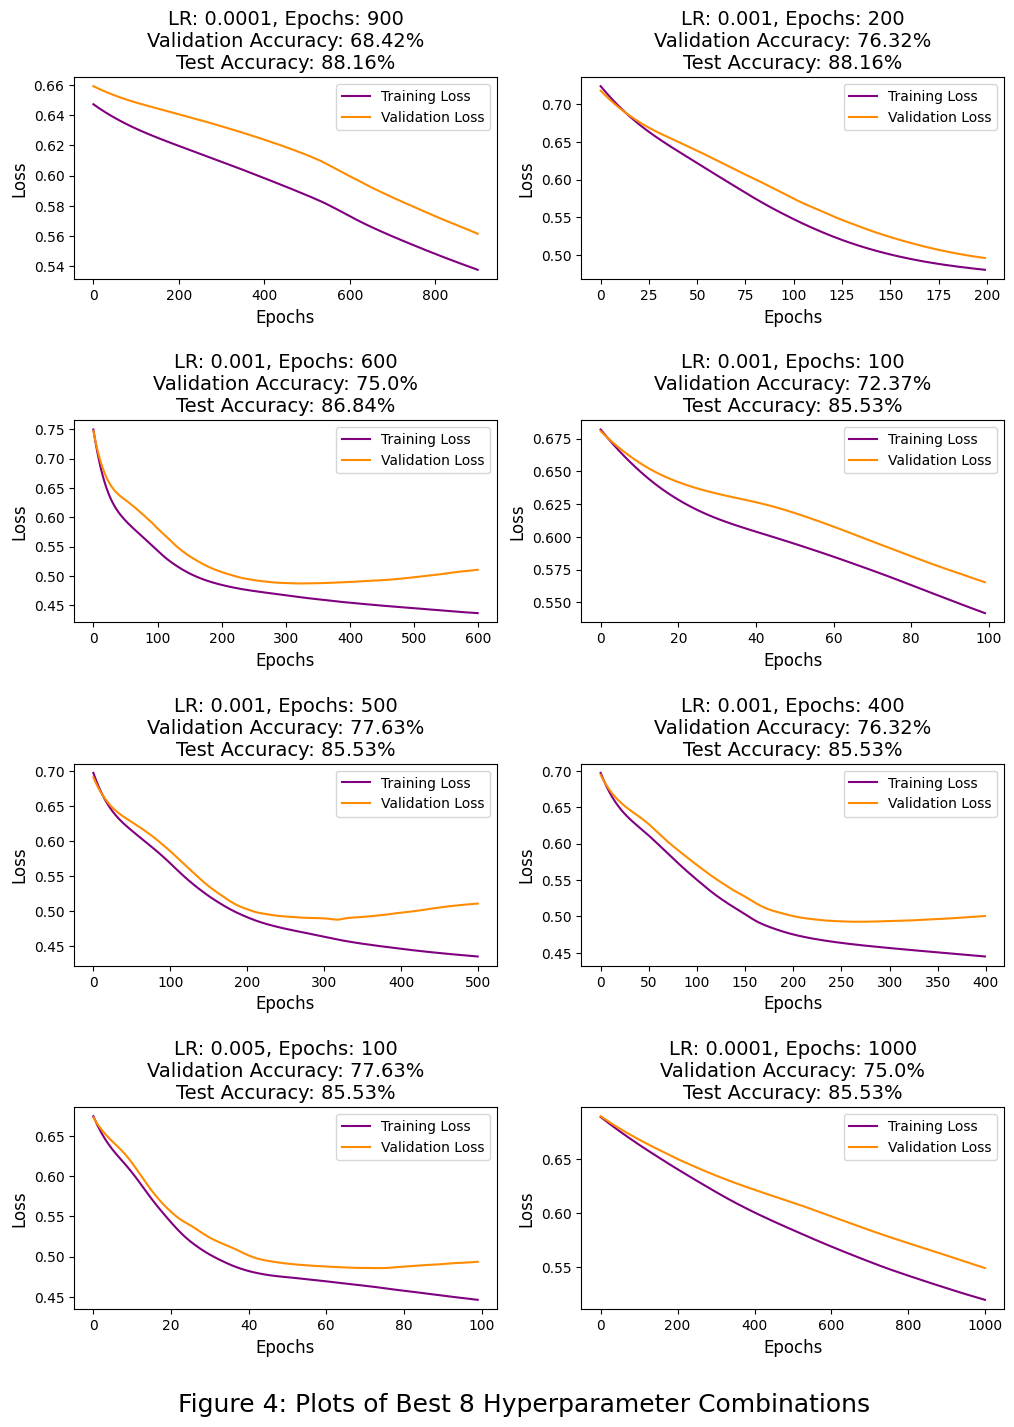

In [ ]:
# Putting the best parameters into a list of tuples
best_parameters = [tuple(row) for row in final_results.head(8).itertuples(index=False)]

# Setting a seed to reproduce the data
torch.manual_seed(1748578)

# Initialising lists to store results, and setting input size
tuning_results = []
input_size = X_train.shape[1]

# Collecting the tuning results
for lr, epoch, valid_accuracy, test_accuracy in best_parameters:
    _, train_losses, valid_losses = MLP_training_function(lr, epoch, input_size)
    tuning_results.append((lr, epoch, train_losses, valid_losses, valid_accuracy, test_accuracy))

# Creating subplots for each learning rate in a 4x2 grid
fig, axes = plt.subplots(4, 2, figsize=(12, 16))
fig.subplots_adjust(hspace=0.7)
axes = axes.flatten()

# Plotting the best results against each other
for i, (lr, epoch, train_losses, valid_losses, valid_accuracy, test_accuracy) in enumerate(tuning_results):
    ax = axes[i]
    ax.plot(train_losses, color="purple", label='Training Loss')
    ax.plot(valid_losses, color="darkorange", label='Validation Loss')
    ax.set_xlabel("Epochs", fontsize=12)
    ax.set_ylabel("Loss", fontsize=12)
    ax.set_title(f"LR: {lr}, Epochs: {epoch}\nValidation Accuracy: {round(valid_accuracy*100, 2)}%\nTest Accuracy: {round(test_accuracy*100, 2)}%", fontsize=14)
    ax.legend(fontsize=10)

# Adding a caption to the plot
plt.text(0.5, 0.05, 'Figure 4: Plots of Best 8 Hyperparameter Combinations', fontsize=18, ha='center', va='center', transform=fig.transFigure, bbox=dict(boxstyle='round,pad=0.5', edgecolor='white', facecolor='white'))

# Plotting the plots
plt.show()


### Getting final test accuracy

In [ ]:
# Setting a seed to reproduce the data
torch.manual_seed(1748578)

# Creating the test accuracy function
def MLP_test_accuracy(model, X_test, y_test, learning_rate, num_epochs, input_size):

    # Creating the model, loss function, and optimiser
    model = ML_Perceptron(input_size)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # Testing loop
    for epoch in range(num_epochs):
        optimizer.zero_grad()
        outputs = model(X_train)
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()

    # Calculating accuracy and returning result
    model.eval()
    with torch.no_grad():
        test_outputs = model(X_test)
        _, preds = torch.max(test_outputs, 1)
        accuracy = (preds == y_test).sum().item() / len(y_test)
    return accuracy

# Best parameters determined from before:
input_size = X_train.shape[1]
lr = 0.005
epochs = 100

# Calculating the final accuracy on the testing set
mlp_model = ML_Perceptron(input_size)
test_accuracy = MLP_test_accuracy(mlp_model, X_test, y_test, lr, epochs, input_size)
print(f"Accuracy on the testing set: {round(test_accuracy*100, 2)}%")


Accuracy on the testing set: 85.53%


### Plotting number of people with diabetes

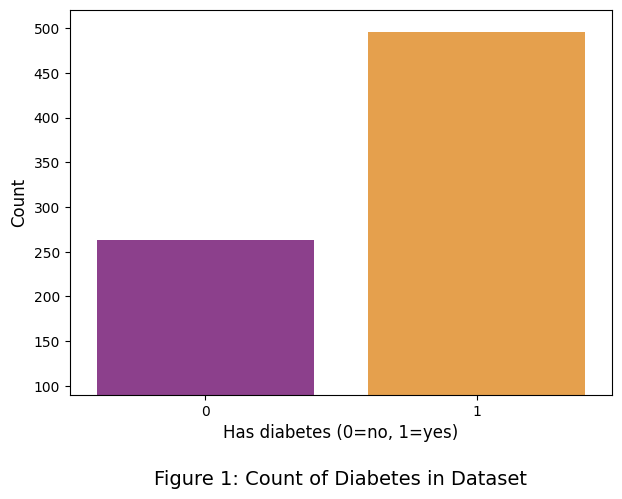

1    496
0    263
Name: outcome, dtype: int64

In [ ]:
import seaborn as sns

patient_count = diabetes['outcome'].value_counts()
cols = ['darkorange' if x < 300 else 'purple' for x in patient_count.values]
plt.figure(figsize=(7,5))
sns.barplot(x=patient_count.index, y=patient_count.values, alpha=0.8, palette=cols)
plt.xlabel("Has diabetes (0=no, 1=yes)", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.text(0.5, -5, 'Figure 1: Count of Diabetes in Dataset', fontsize=14, ha='center', va='center', bbox=dict(boxstyle='round,pad=0.5', edgecolor='white', facecolor='white'))
x1,x2,y1,y2 = plt.axis()
plt.axis((x1,x2,y1 + 90 ,y2))
plt.show()

diabetes['outcome'].value_counts()